# Surface de volatilité

## Objectif générale
L'objectif de cet exercice est de visualiser la surface de volatilité implicite selon 3 axes, x : Strikes Price, y : Days to Expiration, z : Implied Volatility for Put/Call Options.

## Structure du Notebook : 

### Fonctions

1. **Validation du ticker :**
    - Validation du ticker

2. **Calcul de la volatilité implicite avec la formule de Black-Scholes**
    - Calcul du prix d'une option avec Black-Scholes
    - Calcul de la valactilité implicite par résolution numérique
    - Calcul de la volatilité implicite pour une option individuelle
    - Ajout de la volatilité implicite à un DataFrame d'options

3. **Visualisation**
    - Affichage de la surface de volatilité

### Main

# Importantion des bibliothèques nécessaires

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm
from scipy.optimize import brentq
from scipy.interpolate import griddata
from datetime import datetime
import math

# Fonctions

## 1. Validation du ticker

### A. Validation du ticker

Fonction permettant de vérifier la validité d'un ticker saisi par l'utilisateur (par exemple, AAPL ou MSFT) à l'aide de yfinance. Le ticker est retourné uniquement si des données valides sont disponibles sinon l'utilisateur est invité à saisir un autre ticker.

In [2]:
def validate_ticker(default="AAPL"):
    while True:
        ticker = input(f"Entrez le ticker (par ex. AAPL, MSFT, TSLA) (par défaut : {default}) : ").strip().upper()
        ticker = ticker if ticker else default
        stock = yf.Ticker(ticker)
        stock.history(period="1d")
        prices = stock.history(period="1d")
        if not prices.empty:
            return ticker  
        print(f"Le ticker {ticker} n'est pas valide. Veuillez réessayer.")

## 2. Calcul de la volatilité implicite avec la formule de Black-Scholes

### A. Calcul du prix d'une option avec Black-Scholes

Fonction calculant le prix d'une option européenne (Call ou Put) à l'aide de la formule de Black-Scholes. Elle utilise le prix actuel de l'actif \(S\), le prix d'exercice \(K\), le temps à maturité \(T\), le taux sans risque \(r\) et la volatilité \(sigma\). Le calcul repose sur les probabilités cumulées normales \(N(d_1)\) et \(N(d_2)\), retournant le prix actualisé de l'option selon le type spécifié.

In [3]:
def black_scholes_price(S, K, T, r, sigma, option_type):
    d1 = (math.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)
    if option_type.lower() == "call":
        return S * norm.cdf(d1) - K * math.exp(-r * T) * norm.cdf(d2)
    elif option_type.lower() == "put":
        return K * math.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("option_type must be 'Call' or 'Put'.")

### B. Calcul de la volactilité implicite par résolution numérique 

Fonciton permettant de calculer la volatilité implicite d'une option européenne par résolution numérique de Black-Scholes. La volatilité implicite est déterminée en ajustant σ de manière itérative pour que le prix calculé via Black-Scholes corresponde au prix de marché (market_pricemarket_price). La méthode numérique de Brent est utilisée pour trouver la solution dans un intervalle défini. Si aucun résultat ne peut être trouvé, la fonction retourne NaN.

In [4]:
def implied_volatility(S, K, T, r, market_price, option_type):
    def objective_function(sigma):
        return black_scholes_price(S, K, T, r, sigma, option_type) - market_price

    try:
        return brentq(objective_function, 1e-4, 5.0)  # Intervalle
    except ValueError:
        return float('nan') 

### C. Calcul de la volatilité implicite pour une option individuelle

Fonction permettant de calculer la volatilité implicite pour une ligne d’un DataFrame représentant des options. Elle extrait les paramètres nécessaires (prix d’exercice K, temps à maturité T, prix de marché market_price) à partir de la ligne, puis appelle la fonction implied_volatility pour calculer la volatilité implicite. En cas d'erreur (par exemple, données invalides ou problème de calcul), la fonction retourne NaN et affiche un message d'erreur spécifique à la ligne concernée.

In [5]:
def calculate_row_volatility(row, S, r, option_type):
    try:
        K = row['strike']  # Prix d'exercice
        T = (pd.to_datetime(row['expirationDate']) - pd.Timestamp.now()).days / 365  # Temps jusqu'à expiration
        market_price = row['lastPrice']  # Prix de marché
        return implied_volatility(S, K, T, r, market_price, option_type)
    except Exception as e:
        print(f"Erreur sur la ligne {row.name} : {e}")
        return float('nan')

### D. Ajout de la volatilité implicite à un DataFrame d'options

Fonction permettant d’ajouter la colonne de volatilité implicite à un DataFrame d’options. Elle applique la fonction calculate_row_volatility à chaque ligne du DataFrame, en calculant la volatilité implicite pour chaque option en fonction des données spécifiques (prix d'exercice, maturité, prix de marché). Une nouvelle colonne, calculatedImpliedVolatility, est ajoutée au DataFrame avec les résultats.

In [6]:
def add_implied_volatility_to_df(options_df, S, r, option_type):
    options_df['calculatedImpliedVolatility'] = options_df.apply(
        lambda row: calculate_row_volatility(row, S, r, option_type), axis=1
    )
    return options_df

## 3. Visualisation

### A. Affichage de la surface de volatilité

Fonction permettant de tracer une surface 3D représentant la volatilité implicite en fonction du prix d'exercice et du temps à maturité. Les données (strikes, jours jusqu'à expiration et volatilités implicites) sont interpolées pour générer une surface lissée. La surface est affichée sous forme de graphique 3D, avec des axes pour le prix d'exercice (x), les jours jusqu'à expiration (y), et la volatilité implicite (z). Un titre avec les informations actuelles du ticker, du prix et de la date.

In [7]:
def plot_volatility_surface(dataset, option_type, current_price, ticker):
    # Préparer les données pour l'interpolation
    strikes = dataset['strike'].values
    days = dataset['daysToExpiration'].values
    volatilities = dataset['calculatedImpliedVolatility'].values

    # Créer une grille régulière
    grid_x, grid_y = np.meshgrid(
        np.linspace(min(strikes), max(strikes), 100),
        np.linspace(min(days), max(days), 100)
    )

    # Interpoler les données pour lisser la surface
    grid_z = griddata(
        points=(strikes, days),
        values=volatilities,
        xi=(grid_x, grid_y),
        method='cubic'
    )

    # Créer la figure
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Tracer la surface 3D
    surf = ax.plot_surface(
        grid_x, grid_y, grid_z,
        cmap='coolwarm',
        edgecolor='none',
        alpha=0.9
    )

    # Configurer les étiquettes et le titre
    ax.set_xlabel('Strike Price', labelpad=15)
    ax.set_ylabel('Days to Expiration', labelpad=15)
    ax.set_zlabel(f'Implied Volatility for {option_type} Options', labelpad=15)

    # Titre du graphique
    current_date = datetime.now().strftime('%b %d %Y @ %H:%M ET')
    ax.set_title(
        f"Implied Volatility Surface for {ticker.upper()} ({option_type} Options)\n"
        f"Current Price: {current_price:.2f} USD Date: {current_date}",
        pad=20
    )

    # Ajouter une barre de couleur
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

    # Afficher le graphique
    plt.tight_layout()
    plt.show()

# Main 

In [10]:
# Étape 1 : Validation du ticker et récupération des données de base
ticker = validate_ticker()
stock = yf.Ticker(ticker)

S = stock.history(period="1d")['Close'].iloc[-1]

current_date = datetime.now().date()

r = 0.02
r = input("Entrez le taux sans risque (par défaut : 0.02) : ").strip() or r
r = float(r)

In [11]:
# Étape 2 : Récupération des options et des dates d'expiration
expiration_dates = stock.options
print("Dates d'expiration disponibles :", expiration_dates)

Dates d'expiration disponibles : ('2024-12-13', '2024-12-20', '2024-12-27', '2025-01-03', '2025-01-10', '2025-01-17', '2025-01-24', '2025-02-21', '2025-03-21', '2025-04-17', '2025-06-20', '2025-07-18', '2025-08-15', '2025-09-19', '2025-12-19', '2026-01-16', '2026-06-18', '2026-12-18', '2027-01-15')


In [12]:
# Étape 3 : Extraction et traitement des données d'options
options_calls = []
options_puts = []

for date in expiration_dates:
    option_chain = stock.option_chain(date)
    calls = option_chain.calls
    puts = option_chain.puts

    calls['type'] = 'Call'
    puts['type'] = 'Put'
    calls['expirationDate'] = date
    puts['expirationDate'] = date

    calls = calls.sample(n=min(len(calls), 50))
    puts = puts.sample(n=min(len(puts), 50))

    options_calls.append(calls)
    options_puts.append(puts)

calls_df = pd.concat(options_calls, ignore_index=True)
puts_df = pd.concat(options_puts, ignore_index=True)

In [13]:
# Étape 4 : Calcul de la volatilité implicite
calls_with_volatility_calculated = add_implied_volatility_to_df(calls_df, S, r, "Call")
puts_with_volatility_calculated = add_implied_volatility_to_df(puts_df, S, r, "Put")

Erreur sur la ligne 0 : float division by zero
Erreur sur la ligne 1 : float division by zero
Erreur sur la ligne 2 : float division by zero
Erreur sur la ligne 3 : float division by zero
Erreur sur la ligne 4 : float division by zero
Erreur sur la ligne 5 : float division by zero
Erreur sur la ligne 6 : float division by zero
Erreur sur la ligne 7 : float division by zero
Erreur sur la ligne 8 : float division by zero
Erreur sur la ligne 9 : float division by zero
Erreur sur la ligne 10 : float division by zero
Erreur sur la ligne 11 : float division by zero
Erreur sur la ligne 12 : float division by zero
Erreur sur la ligne 13 : float division by zero
Erreur sur la ligne 14 : float division by zero
Erreur sur la ligne 15 : float division by zero
Erreur sur la ligne 16 : float division by zero
Erreur sur la ligne 17 : float division by zero
Erreur sur la ligne 18 : float division by zero
Erreur sur la ligne 19 : float division by zero
Erreur sur la ligne 20 : float division by zero
Er

In [14]:
# Étape 5 : Préparation des données pour le tracé
plot_call = calls_with_volatility_calculated[['strike', 'expirationDate', 'calculatedImpliedVolatility']].copy()
plot_put = puts_with_volatility_calculated[['strike', 'expirationDate', 'calculatedImpliedVolatility']].copy()

plot_call['daysToExpiration'] = plot_call['expirationDate'].apply(lambda x: (pd.to_datetime(x).date() - current_date).days)
plot_put['daysToExpiration'] = plot_put['expirationDate'].apply(lambda x: (pd.to_datetime(x).date() - current_date).days)

plot_call.drop(columns=['expirationDate'], inplace=True)
plot_put.drop(columns=['expirationDate'], inplace=True)

plot_call.dropna(inplace=True)
plot_put.dropna(inplace=True)

plot_call.reset_index(drop=True, inplace=True)
plot_put.reset_index(drop=True, inplace=True)

print("\nDonnées pour le tracé des Calls :")
print(plot_call)

print("\nDonnées pour le tracé des Puts :")
print(plot_put)


Données pour le tracé des Calls :
     strike  calculatedImpliedVolatility  daysToExpiration
0     140.0                     1.926257                 8
1     255.0                     0.208515                 8
2     267.5                     0.235176                 8
3     257.5                     0.211119                 8
4     260.0                     0.215304                 8
..      ...                          ...               ...
580   115.0                     0.408611               764
581   160.0                     0.380973               764
582   195.0                     0.323884               764
583   340.0                     0.243106               764
584   120.0                     0.386135               764

[585 rows x 3 columns]

Données pour le tracé des Puts :
     strike  calculatedImpliedVolatility  daysToExpiration
0     150.0                     1.190123                 8
1     210.0                     0.523177                 8
2     227.5           

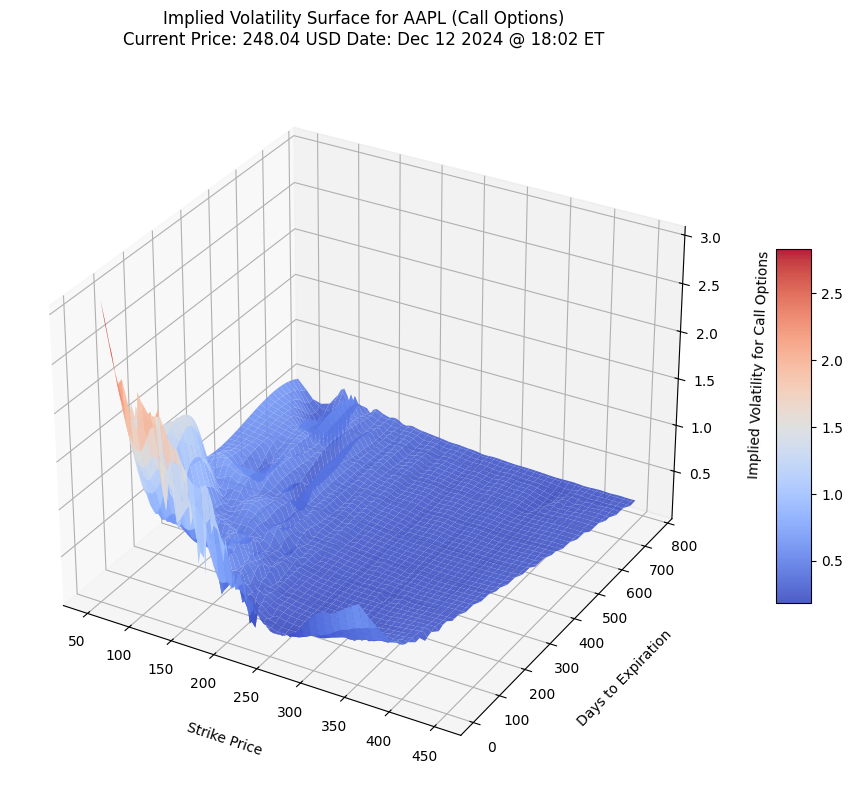

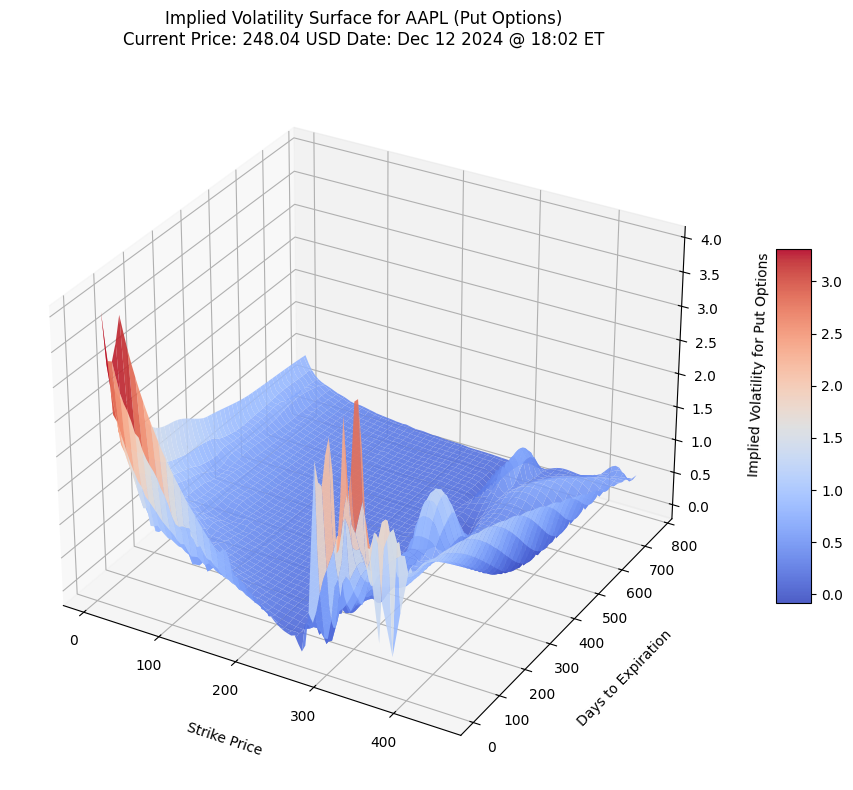

In [15]:
# Étape 6 : Tracé de la surface de volatilité
plot_volatility_surface(plot_call, "Call", S, ticker)
plot_volatility_surface(plot_put, "Put", S, ticker)
